# Notebook for preliminary data analysis

In [2]:
%run ./rob_setup_notebook.ipynb
    
import utils.ia_funcs as ia 
import utils.utils_funcs as uf
import utils.gsheets_importer as gsi
from utils.paq2py import *

session_type = 'sensory_2sec_test'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Suite2p path: ['/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/suite2p']
qnap_path: /home/rlees/mnt/qnap 
qnap_data_path /home/rlees/mnt/qnap/Data 
pkl_folder: /home/rlees/mnt/qnap/pkl_files 
master_path: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
fig_save_path: /home/rlees/mnt/qnap/Analysis/Figures 
stam_save_path: /home/rlees/mnt/qnap/Analysis/STA_movies 
s2_borders_path: /home/rlees/mnt/qnap/Analysis/S2_borders


# Plot target circles on image

In [16]:
# Target overlay on whisker 2P image
# whisker 2P image path
# targets from the same animal RL101 
# plot target coords with circle scatterplot - color differently for pr and ps

# w2p_img = tf.imread(os.path.join(qnap_data_path, '2021-01-20', 'RL124', '2021-01-20_RL124_s-003', 
#                                  '2021-01-20_RL124_s-003_Cycle00001_Ch2_000001.ome.tif'))

# w2p_img = tf.imread(os.path.join(qnap_data_path, '2020-10-29', 'RL111', '2020-10-29_RL111_s-003',  
#                                  '2020-10-29_RL111_s-003_Cycle00001_Ch1_000001.ome.tif'))

w2p_img = tf.imread(os.path.join(qnap_data_path, '2020-09-14', 'RL101', '2020-09-14_RL101_s-001', 
                                 '2020-09-14_RL101_s-001_Cycle00001_Ch2_000001.ome.tif'))

# w2p_img = tf.imread(os.path.join(stam_save_path, 
#                                  '2020-09-14_RL101_t-002_Stim1_STA_Plane1_dFF_AvgImage.tif'))

# '2020-09-14_RL101_t-008_Cycle00001_Ch3_Stim1_STA_Plane1_dFF_AvgImage'
# '2020-09-14_RL101_t-007_Cycle00001_Ch3_Stim1_STA_Plane1_dFF_AvgImage'
# '2020-09-14_RL101_t-002_Stim1_STA_Plane1_dFF_AvgImage'

/home/rlees/anaconda3/envs/suite2p/lib/python3.7/site-packages/tifffile/tifffile.py:12440: RuntimeWarning: invalid value encountered in true_divide
  'ZDistance': values[:, 0] / values[:, 1],


In [126]:
def s2pMasks(s2p_path, cell_ids, values):
    '''Return image of cell masks with pixel value corresponding to index
    
    Inputs:
        s2p_path -- directory with outputs from Suite2p ('save_path0')
        cell_ids -- indices of cells to add to the image
        values   -- values to fill the masks with (default is cell_ids)
    
    Returns:
        mask_img -- 2D uint16 array with cell ROIs filled with cell index value
    '''

    os.chdir(s2p_path)

    stat = np.load('stat.npy', allow_pickle=True)
    ops = np.load('ops.npy', allow_pickle=True).item()
    iscell = np.load('iscell.npy', allow_pickle=True)           
    
    mask_img = np.zeros((ops['Ly'], ops['Lx']), dtype='int16')

    for n in range(0,len(iscell)):
        if n in cell_ids:
            ypix = stat[n]['ypix']
            xpix = stat[n]['xpix']
            mask_img[ypix,xpix] = values[np.where(np.array(cell_ids) == n)[0]]*100
    
    return mask_img

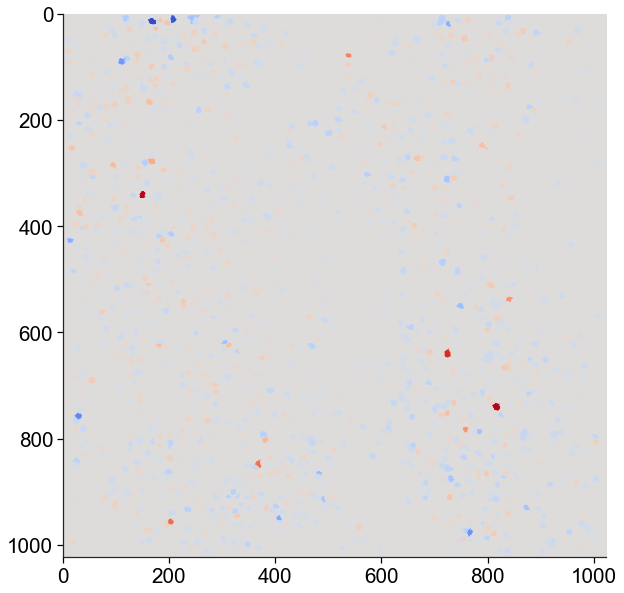

In [127]:
s2p_path = '/home/rlees/mnt/qnap/Data/2020-09-14/RL101/2020-09-14_RL101_t-007/suite2p/plane0'
cell_ids = ses_obj.spont.cell_id[0]
values = ses_obj.spont.sta_amplitudes[0]

mask_img = s2pMasks(s2p_path, cell_ids, values)

plt.figure(figsize=(10,10))
plt.imshow(mask_img, vmin=-50, vmax=50, cmap='coolwarm')

In [5]:
pkl_files = ia.listdirFullpath(os.path.join(pkl_folder, session_type), string='RL101.pkl')

# pkl_files = ia.listdirFullpath(os.path.join(pkl_folder, 'interneuron'), string='20_RL124.pkl')

for pkl in pkl_files:
        
    ses_obj = ia.loadPickle(pkl)

Loading pickle: /home/rlees/mnt/qnap/pkl_files/sensory_2sec_test/2020-09-14_RL101.pkl


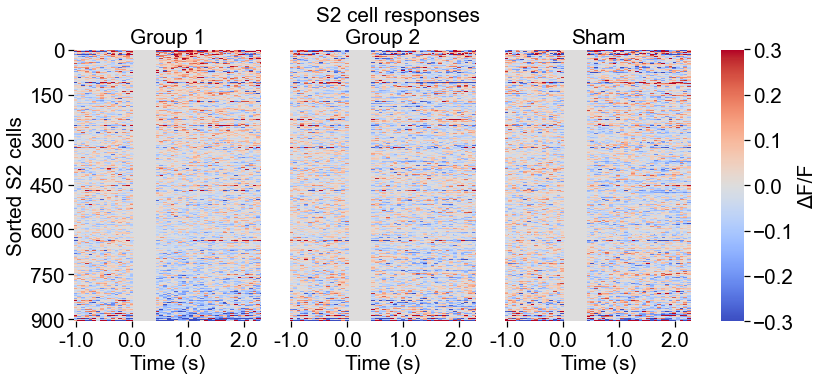

In [112]:
exp_obj = ses_obj.photostim_r
s2_cells = exp_obj.cell_s2[0]
s2_stas = exp_obj.stas[0][s2_cells]
sorted_s2_stas = s2_stas[sorted_idxs[::-1]]
s2_post_stim = s2_stas[:,38:50]
s2_mean_post_stim = np.mean(s2_post_stim, axis=1)
sorted_idxs = np.argsort(s2_mean_post_stim)

fig, axes = plt.subplots(1,4,figsize=(12,5), gridspec_kw={'width_ratios' : [2,2,2,0.25]})

group_labels = ['Group 1', 'Group 2', 'Sham']

for i, (ax, group_label, exp_obj) in enumerate(zip(axes[:3], 
                                                   group_labels, 
                                                   [ses_obj.photostim_r, 
                                                    ses_obj.photostim_s, 
                                                    ses_obj.spont])):
    fps = exp_obj.fps

    s2_cells = exp_obj.cell_s2[0]
    s2_stas = exp_obj.stas[0][s2_cells]
    sorted_s2_stas = s2_stas[sorted_idxs[::-1]]

    xticks = (np.array( range(0,len(sorted_s2_stas[0]))  ) / fps) - 2
    xticks = xticks.round()
    xticks[xticks==-0] = 0

    sta_df = pd.DataFrame(sorted_s2_stas, columns=xticks)
    
    if i == 0:
        sns.heatmap(sta_df, vmin=-0.3, vmax=0.3, cmap='coolwarm', yticklabels=150, 
                    xticklabels=15, ax=ax, cbar=False)
        ax.set_ylabel('Sorted S2 cells');
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    elif i == 2:
        sns.heatmap(sta_df, vmin=-0.3, vmax=0.3, cmap='coolwarm', yticklabels=150, 
                    xticklabels=15, ax=ax, cbar=True, cbar_ax=axes[3])
        ax.set_ylabel('');
        ax.set_yticks([])
    else:
        sns.heatmap(sta_df, vmin=-0.3, vmax=0.3, cmap='coolwarm', yticklabels=150, 
                    xticklabels=15, ax=ax, cbar=False)
        ax.set_ylabel('');
        ax.set_yticks([])
    
    ax.set_title(group_label)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlim([15, 65]);
    ax.set_xlabel('Time (s)');
    
axes[3].set_ylabel('ΔF/F')
plt.suptitle('S2 cell responses', fontsize='xx-large', y=1);

fig_dir = os.path.join(fig_save_path, 'S1S2_mechanisms_panels', '')
save_path = fig_dir + 'RL101_s2_responses_heatmap'
ia.savePlot(save_path)

In [6]:
rand_target_coords = np.array([[x,y] for (x,y) in ses_obj.photostim_r.target_coords])
sens_target_coords = np.array([[x,y] for (x,y) in ses_obj.photostim_s.target_coords])

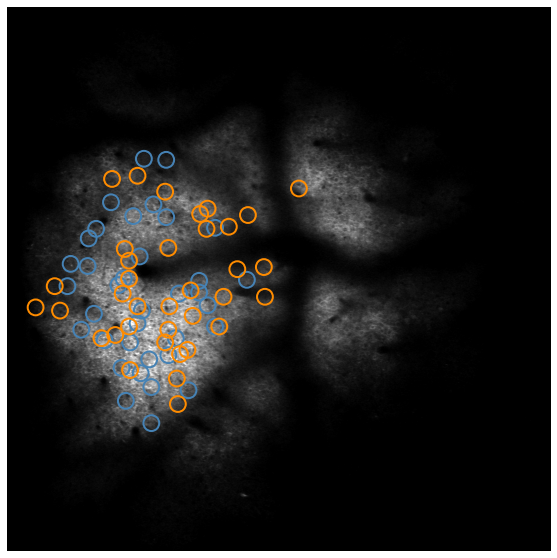

In [19]:
target_coords = [
    rand_target_coords, 
    sens_target_coords
]
target_colors = [
    'steelblue', 
    'darkorange'
]
# target_colors = [
#     'yellow', 
#     'yellow'
# ]

plt.figure(figsize=(10,10))
# plt.imshow(w2p_img, cmap='gray', vmin=0, vmax=30)
plt.imshow(w2p_img, cmap='gray', vmin=100, vmax=3500)
# plt.imshow(mask_img, cmap='coolwarm', vmin=-35, vmax=35)
plt.axis('off')
    
for coords, color in zip(target_coords, target_colors):
    plt.scatter(coords[:,1], coords[:,0], 
                facecolors='none', edgecolors=color, marker='.', s=1000,
                linewidths=2
               )
#     plt.scatter(targ_cell_meds[25][1], targ_cell_meds[25][0], color='k', s=1000)
    
fig_dir = os.path.join(fig_save_path, 'S1S2_mechanisms_panels', '')
save_path = fig_dir + 'RL101_c1v1_2p_target_overlay'
ia.savePlot(save_path)

In [4]:
exp_obj = ses_obj.photostim_r

targ_bool = exp_obj.targeted_cells
targ_cell_meds = np.array(exp_obj.cell_med[0])[targ_bool]
targ_stas = np.array(exp_obj.stas[0])[targ_bool]

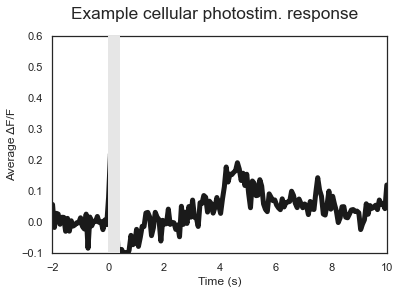

In [9]:
fig, ax = plt.subplots()
plt.plot(ses_obj.photostim_s.time, targ_stas[25], lw=5, color='k')
plt.xlabel('Time (s)')
plt.ylabel('Average ΔF/F')
plt.suptitle('Example cellular photostim. response', fontsize='xx-large')

stim_patch = patches.Rectangle((-0.005,-100), 0.400, 999, zorder=3, color='0.9')
ax.add_patch(stim_patch)
# ax.text(0.5, -0.05, 'Photostimulation', fontsize='x-large', color='lightpink')
plt.axis([-2, 10, -0.1, 0.6])

fig_dir = os.path.join(fig_save_path, 'S1S2_mechanisms_panels', '')
save_path = fig_dir + 'RL101_photostim_r_example_target_plot'
# ia.savePlot(save_path)

## Gain calculations from plastic slide images

In [ ]:
path = '/home/apacker/mnt/qnap/Data/2021-10-19/'

all_dirs = np.sort([folder for folder in os.listdir(path) if '_t' in folder])

dir_lists = [all_dirs[14:], all_dirs[7:14], all_dirs[:7]]
pmt_gains = ['700', '600', '500']
powers = [50, 80, 110, 140, 170, 200, 230]
channels = ['Ch2', 'Ch3']
markers = ['o', '^', 'x']

m = np.empty([len(channels), len(pmt_gains), len(powers)])
v = np.empty([len(channels), len(pmt_gains), len(powers)])

for ch_i, channel in enumerate(channels):    
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    for gain_i, (pmt_gain, dir_list, marker) in enumerate(zip(pmt_gains, dir_lists, markers)):
        for power_i, (power, folder) in enumerate(zip(powers, dir_list)):
            for file in os.listdir(os.path.join(path, folder)):
                if all(s in file for s in [channel, '.tif']):
                    tiff = tf.imread(os.path.join(path, folder, file))

                    m[ch_i, gain_i, power_i] = np.mean(tiff)
                    v[ch_i, gain_i, power_i] = np.var(tiff, ddof=1)
                    
                    print(channel, pmt_gain, power, 'done')
        
        plt.scatter(m[ch_i, gain_i], v[ch_i, gain_i], color='k', label=pmt_gain + 'V', marker=marker)
        plt.legend()
        
        slope, intercept, r_value, p_value, se = stats.linregress(m[ch_i, gain_i], v[ch_i, gain_i])
        y = (slope*m[ch_i, gain_i]) + intercept
        plt.plot(m[ch_i, gain_i], y, color='r')
        
        ax = plt.gca()
        text_x = ax.get_xlim()[1]/2
        plt.text(text_x, np.median(v[ch_i, gain_i]), 'Slope = {0:.2f}'.format(slope))
        
    axes.set_xlabel('Mean pixel value')
    axes.set_ylabel('Variance of pixel values')
    axes.set_title('Channel = ' + channel)
    
    save_path = os.path.join(qnap_path, channel + '_gain_mean_vs_variance_plot')
    ia.savePlot(save_path)

### Add or check attributes in all session objects

In [ ]:
sheet_names = ['2019-06-11_J048',
                '2019-06-13_J052',
                '2019-06-25_RL048',
                '2019-07-15_RL052',
                '2019-08-14_J058',
                '2019-08-14_J059',
                '2019-08-15_RL055',
                '2019-11-14_J061',
                '2019-11-14_J063',
                '2019-11-15_J064',
                '2019-11-18_J065',
                '2020-02-27_RL075',
                '2020-03-03_RL074',
                '2020-03-05_RL070',
                '2020-03-05_RL072']

s1s2_coords = [[294, 119, 750, 166],
                [213, 165, 735, 234],
                [148, 203, 760, 175],
                [177, 332, 825, 404],
                [291, 183, 715, 345],
                [148, 114, 764, 203],
                [132, 273, 659, 328],
                [341, 453, 700, 535],
                [264, 481, 657, 605],
                [412, 440, 703, 580],
                [304, 515, 637, 625],
                [239, 452, 571, 456],
                [244, 453, 743, 567],
                [269, 429, 843, 520],
                [327, 519, 807, 607]]

# # To add s1/s2 coords to pickled objects
# for sheet_name, [s1_x, s1_y, s2_x, s2_y] in zip(sheet_names, s1s2_coords):
#     if sheet_name in pkl:
#         ses_obj.s1_coord = [s1_x, s1_y]
#         ses_obj.s2_coord = [s2_x, s2_y]

In [ ]:
pkl_files = [p for p in os.listdir(pkl_folder) if '.pkl' in p]
pkl_files.sort()

for pkl in pkl_files:
        
    print(pkl)

    pkl_path = os.path.join(pkl_folder, pkl)

    with open(pkl_path, 'rb') as f:
        ses_obj = pickle.load(f)

    exp_list = [ses_obj.photostim_r, ses_obj.photostim_s]

    if ses_obj.spont.n_frames > 0:
        exp_list.append(ses_obj.spont)

    if ses_obj.whisker_stim.n_frames > 0:
        exp_list.append(ses_obj.whisker_stim)

    for exp_obj in exp_list:

#     with open(pkl_path, 'wb') as f:
#         pickle.dump(ses_obj, f)

## Smoothing line plots

In [ ]:
box_pts=4
box = np.ones(box_pts)/box_pts
y_smooth = np.convolve(y, box, mode='same')
print(y_smooth[0:5], y[:5])

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
cell = 4

y = smooth(exp_obj.all_trials[0][cell,:,0], 4)
    
plt.figure(figsize=(15,5))
plt.plot(y);
plt.plot(exp_obj.all_trials[0][cell,:,0])
plt.hlines(0, xmin=0, xmax=180, linestyles='dashed');

### Play with data from individual session objects

In [ ]:
# List of pickle object file names, i.e. experiments that have been analysed
# '2019-06-11_J048', # -- OBFOV shallow 
# '2019-06-13_J052', # -- OBFOV shallow 
# '2019-06-25_RL048', # -- OBFOV shallow 
# '2019-07-15_RL052', # -- OBFOV shallow 
# '2019-08-14_J058', # -- OBFOV shallow 
# '2019-08-14_J059', # -- OBFOV shallow 
# '2019-08-15_RL055', # -- OBFOV shallow 
# '2019-11-14_J061', # -- shallow 
# '2019-11-14_J063', # -- shallow
# '2019-11-15_J064', # -- shallow
# '2019-11-18_J065', # -- shallow
# '2020-02-27_RL075', # -- shallow
# '2020-03-03_RL074', # -- shallow
# '2020-03-05_RL070', # -- shallow
# '2020-03-05_RL072', # -- shallow
# '2020-06-03_RL086', # -- shallow (JR stim)
##===NOT ANALYSED===##
# '2020-03-12_RL070', # -- deep
# '2020-03-16_RL074', # -- deep
# '2020-03-19_RL075', # -- deep
# '2020-06-08_RL086', # -- deep
##===NOT ANALYSED===##
# '2020-06-15_RL086', # -- auditory
# '2020-03-20_RL080', # -- shallow (failed)
# '2020-09-03_RL091', # -- shallow
# '2020-09-04_RL093', # -- shallow
# '2020-09-08_RL095', # -- shallow
# '2020-09-08_RL099', # -- shallow
# '2020-09-09_RL096', # -- shallow
# '2020-09-09_RL100', # -- shallow
# '2020-09-14_RL101', # -- shallow
# '2020-09-15_RL102', # -- shallow
# '2020-09-16_RL103', # -- shallow
# '2020-10-02_RL108', # -- shallow
# '2020-10-12_RL109', # -- shallow
# '2020-10-29_RL111', # -- projection
# '2020-12-10_RL115', # -- projection
# '2021-01-06_RL120', # -- interneuron
# '2021-01-20_RL121', # -- interneuron
# '2021-01-20_RL125', # -- interneuron
# '2021-01-20_RL124', # -- interneuron
# '2021-01-28_RL124', # -- interneuron
# '2021-02-18_RL127', # -- projection
# '2021-02-22_RL128', # -- projection
# '2021-02-23_RL129', # -- projection
# '2021-02-24_RL132', # -- projection
# '2021-02-25_RL131', # -- projection
# '2021-03-02_RL130', # -- projection

pkl_path = os.path.join(pkl_folder, 'sensory', '2020-09-04_RL093.pkl')

with open(pkl_path, 'rb') as f:
    ses_obj = pickle.load(f)
    
print('Loaded pickled object.')

In [ ]:
# Show all attributes in ses_obj or exp_objs
print('Session object attributes')
for key, value in vars(ses_obj).items():
    print(key, type(value))

print('\nExperimental object attributes')
for key, value in vars(ses_obj.spont).items():
    print(key, type(value))